# Data Pipeline
Initial data analysis pipeline including a naive sentiment analysis using TextBlob.

In [1]:
import re
import spacy
import pandas as pd
import numpy as np
from pathlib import Path
from string import punctuation

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import calmap # for making GitHub-style calendar plots of time-series
# Plot using Pandas datatime objects
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
rc_fonts = {'figure.figsize': (15, 8),
            'axes.labelsize': 16,
            'xtick.labelsize': 14,
            'ytick.labelsize': 14}
plt.rcParams.update(rc_fonts)
plt.style.use('ggplot')

## Use ```spaCy``` for tokenization and sentence segmentation

In [4]:
import spacy
from spacy import displacy
# Load spaCy language model (blank model to which we add pipeline components)
sentencizer = spacy.blank('en')
sentencizer.add_pipe(sentencizer.create_pipe('sentencizer'))

#### Specify named entity of interest

In [5]:
name = "United Airlines"

#### Write data: Boolean
Specify if we want to write the output data to csv or not.

In [6]:
write_ = False

In [7]:
datafile = 'all_the_news_v2.csv'
datapath = Path('../') / 'data' / datafile 
colnames = ['title', 'author', 'date', 'content', 'year', 'month', 'publication', 'length']

news = pd.read_csv(datapath, usecols=colnames, parse_dates=['date'])
news['author'] = news['author'].str.strip()
news.head()

,title,author,date,content,year,month,publication,length
0,Agent Cooper in Twin Peaks is the audience: on...,Tasha Robinson,2017-05-31,And never more so than in Showtime’s new...,2017.0,5.0,Verge,2376
1,"AI, the humanity!",Sam Byford,2017-05-30,AlphaGo’s victory isn’t a defeat for hum...,2017.0,5.0,Verge,2125
2,The Viral Machine,Kaitlyn Tiffany,2017-05-25,Super Deluxe built a weird internet empi...,2017.0,5.0,Verge,3310
3,How Anker is beating Apple and Samsung at thei...,Nick Statt,2017-05-22,Steven Yang quit his job at Google in th...,2017.0,5.0,Verge,3632
4,Tour Black Panther’s reimagined homeland with ...,Kwame Opam,2017-05-15,Ahead of Black Panther’s 2018 theatrical...,2017.0,5.0,Verge,262


In [8]:
news = news.dropna(subset=['date', 'title'])
news.shape[0]

143156

In [9]:
news['date'].describe()

count                  143156
unique                   1480
top       2017-01-13 00:00:00
freq                      415
first     2000-05-15 00:00:00
last      2017-07-05 00:00:00
Name: date, dtype: object

### Filter articles based on name match
In this section we only select those news articles that contain part of or all of the name we input as ```name```.

In [10]:
def check_name(content, name):
    flag = False
    if name in content:
        flag = True
    return flag

def filter_df(df):
    df['match'] = df['content'].apply(lambda x: check_name(x, name))
    df_relevant = df.loc[df['match'].eq(True)]
    return df_relevant.drop(['match'], axis=1)

news_relevant = filter_df(news)
print(news_relevant.shape[0])
news_relevant.head()

255


,title,author,date,content,year,month,publication,length
2769,Today: Obamacare Survives the GOP and Trump’s ...,Los Angeles Times,2017-03-27,"I\'m Davan Maharaj, editor-in-chief of the Los...",2017.0,3.0,Los Angeles Times,2195
2799,American Airlines buys $200-million stake in C...,Associated Press,2017-03-27,American Airlines has agreed to pay $200 milli...,2017.0,3.0,Los Angeles Times,1140
2867,Rival airlines poke fun at United over legging...,Los Angeles Times,2017-03-30,United Airlines has taken a heap of criticism ...,2017.0,3.0,Los Angeles Times,966
3058,United fiasco shows airlines' power over passe...,"David Ng, Hugo Martin, Samantha Masunaga",2017-04-11,"Delta, American and United airlines claim the ...",2017.0,4.0,Los Angeles Times,2062
3064,"Facing harsh criticism, airlines can now point...",Hugo Martin,2017-04-25,Facing harsh criticism over several recent sca...,2017.0,4.0,Los Angeles Times,1048


### Perform sentence segmentation
Store the sentences in each news articles as a list of sentences, from which we can easily extract per-sentence sentiment.

In [11]:
def get_relevant(text, name):
    doc = sentencizer(text)
    relevant = []
    for sent in doc.sents:
        for n in name.split():
            if n in sent.text:
                clean = sent.text.replace("\n", " ").replace("\xa0", " ")
                # Strip bad characters at the start of sentences
                clean = clean.strip("[\'").strip("\']").strip('\"').strip("\'\"")
                clean = clean.strip(",\'").strip("\',").strip('\"').strip("\'\"").strip()
                relevant.append(clean)
    # Remove duplicates
    relevant = list(dict.fromkeys(relevant))
    return relevant

In [12]:
news_relevant['relevant'] = news_relevant['content'].apply(lambda x: get_relevant(x, name))

In [13]:
for i in news_relevant['relevant'][:5]:
    print(i, '\n--')

["The Atlantic)', '-- The United Airlines leggings controversy that took social media by storm. ("] 
--
["American Airlines has agreed to pay $200 million for a stake in China Southern Airlines, one of the country\\'s three major state-owned carriers, and expand commercial cooperation.',", "China Southern Airlines said in an announcement Tuesday through the Hong Kong stock exchange that the purchase will represent 2.76% of its shares.',", "Chinese spending on air travel rose 10% in 2015, compared with 1.7% in the United States, according to the International Air Travel Assn.',", 'Two years ago, Delta Air Lines paid $450 million for 3.55% of China Eastern Airlines.', "The third major U.S. carrier, United Airlines, has a partnership with Air China, the third major Chinese government-owned airline.',", "Regulators in both China and the United States are reluctant to allow large foreign ownership stakes or management control of their airlines.',", 'The partnership with American Airlines "i

### Sentiment scoring using FastText

In [14]:
import fastText
# Load trained fastText model
model_path = './fasttext_models/pretrained_yelp_review_full.ftz'

#### Preprocess text and tokenize as per FastText requirements

In [15]:
def fasttext_tokenize(string):
    string = string.lower()
    string = re.sub(r"([.!?,'/()])", r" \1 ", string)
    return string

In [16]:
# reviews = [
#     "This restaurant literally changed my life. This is the best food I've ever eaten!",
#     "I hate this place so much. They were mean to me.",
#     "I don't know. It was ok, I guess. Not really sure what to say.",
# ]

# preprocessed_reviews = list(map(strip_formatting, reviews))
# # Load classifier
# classifier = fastText.load_model(model_path)

# # Get fastText to classify each review with the model
# labels, probabilities = classifier.predict(preprocessed_reviews, 1)
# stars = [int(l[0][-1]) - 3 for l in labels]
# stars

In [17]:
classifier = fastText.load_model(model_path)
def get_score_fasttext(text_list):
    # Calculate polarity for each sentence
    preprocessed = list(map(fasttext_tokenize, text_list))
    labels, probabilities = classifier.predict(preprocessed, 1)
    sentiment_list = [(int(l[0][-1]) - 3)/2 for l in labels if l]
    score = np.mean(sentiment_list)
    deviation = np.std(sentiment_list)
    return score, deviation

In [18]:
news_relevant['score'], news_relevant['deviation'] = zip(*news_relevant['relevant'].map(get_score_fasttext))
news_relevant.head(5)

,title,author,date,content,year,month,publication,length,relevant,score,deviation
2769,Today: Obamacare Survives the GOP and Trump’s ...,Los Angeles Times,2017-03-27,"I\'m Davan Maharaj, editor-in-chief of the Los...",2017.0,3.0,Los Angeles Times,2195,"[The Atlantic)', '-- The United Airlines leggi...",1.000000,0.000000
2799,American Airlines buys $200-million stake in C...,Associated Press,2017-03-27,American Airlines has agreed to pay $200 milli...,2017.0,3.0,Los Angeles Times,1140,[American Airlines has agreed to pay $200 mill...,-0.562500,0.526634
2867,Rival airlines poke fun at United over legging...,Los Angeles Times,2017-03-30,United Airlines has taken a heap of criticism ...,2017.0,3.0,Los Angeles Times,966,[United Airlines has taken a heap of criticism...,0.500000,0.500000
3058,United fiasco shows airlines' power over passe...,"David Ng, Hugo Martin, Samantha Masunaga",2017-04-11,"Delta, American and United airlines claim the ...",2017.0,4.0,Los Angeles Times,2062,"[Delta, American and United airlines claim the...",-0.700000,0.600000
3064,"Facing harsh criticism, airlines can now point...",Hugo Martin,2017-04-25,Facing harsh criticism over several recent sca...,2017.0,4.0,Los Angeles Times,1048,"[As always, competition drives pricing and com...",-0.166667,0.849837


### Lemmatize relevant sentences for comparison
This is to remove duplicates.

In [19]:
add_removed_words = {n for n in name.split()}
# Include specific words to be removed
stopwords = sentencizer.Defaults.stop_words
stopwords = stopwords.union(add_removed_words)

In [20]:
# Tokenize and lemmatize text
def lemmatize(text):
    doc = sentencizer(text)
    tokens = [str(tok.lemma_).lower() for tok in doc if tok.text not in stopwords \
              and tok.text not in punctuation]
    return tokens

In [21]:
news_relevant['lemmas'] = news_relevant['relevant'].str.join(' ').apply(lemmatize).str.join(' ')
news_relevant[['relevant', 'lemmas']].head()

,relevant,lemmas
2769,"[The Atlantic)', '-- The United Airlines leggi...",the atlantic -- the legging controversy take s...
2799,[American Airlines has agreed to pay $200 mill...,american agree pay 200 million stake china sou...
2867,[United Airlines has taken a heap of criticism...,take heap criticism celebrity air traveler dec...
3058,"[Delta, American and United airlines claim the...",delta american airline claim right eject flier...
3064,"[As always, competition drives pricing and com...",as competition drive price competition alive e...


### Drop duplicates

In [22]:
news_relevant = news_relevant.drop_duplicates(subset=['lemmas'])
news_relevant.shape[0]

245

#### Positive sentiment group

In [23]:
pos = news_relevant[news_relevant['score'] > 0.0].sort_values(by=['score'], ascending=False).reset_index(drop=True)
print("Found {} overall positive articles for {}".format(pos.shape[0], name))
pos.head(3)

Found 40 overall positive articles for United Airlines


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,Today: Obamacare Survives the GOP and Trump’s ...,Los Angeles Times,2017-03-27,"I\'m Davan Maharaj, editor-in-chief of the Los...",2017.0,3.0,Los Angeles Times,2195,"[The Atlantic)', '-- The United Airlines leggi...",1.0,0.0,the atlantic -- the legging controversy take s...
1,"The extraordinary Simone Biles, the best athle...",Bryan Armen Graham,2016-08-03,The floor of the XL Center is a blur of pint-s...,2016.0,8.0,Guardian,2735,"[By contrast, Biles, who signed with Nike last...",1.0,0.0,by contrast biles sign nike year deal hershey ...
2,Please stop sending me pointless surveys,Sara Stewart,2017-03-10,Congratulations! You’ve been chosen to answer ...,2017.0,3.0,New York Post,606,[Does the sight of a customer satisfaction que...,1.0,0.0,does sight customer satisfaction questionnaire...


#### Write positive results

In [24]:
if write_:
    out_filename = '_'.join(name.split()).lower() + '_pos.csv'
    out_path = Path('./') / "results/fasttext" / out_filename
    pos.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                    .to_csv(out_path, index=False, header=True)

#### Negative sentiment group

In [25]:
neg = news_relevant[news_relevant['score'] < 0.0].sort_values(by=['score']).reset_index(drop=True)
print("Found {} overall negative articles for {}".format(neg.shape[0], name))
neg.head(3)

Found 190 overall negative articles for United Airlines


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,Actress Carrie Fisher suffers medical emergenc...,Steve Gorman and Alex Dobuzinskis,2016-12-24,"Hollywood actress and writer Carrie Fisher, b...",2016.0,12.0,Reuters,915,[United Airlines issued a statement saying tha...,-1.0,0.0,issue statement say flight 935 london los ange...
1,United responds after shocking video shows doc...,Benjamin Zhang,2017-04-11,['\n A passenger was forcibly removed from a ...,2017.0,4.0,Business Insider,380,"[United airlines overbooked the flight., unite...",-1.0,0.0,airline overbook flight unitedairways \n in ...
2,Emirates just launched a new flight to New Yor...,Benjamin Zhang,2017-01-26,"['\n\n', '\n Get ready. You will soon be able...",2017.0,1.0,Business Insider,605,"[Currently, Delta and United only operate seas...",-1.0,0.0,currently delta operate seasonal\n service g...


#### Write negative results

In [26]:
if write_:
    out_filename = '_'.join(name.split()).lower() + '_neg.csv'
    out_path = Path('./') / "results/fasttext" / out_filename
    neg.sort_values(by='publication')[['publication', 'title', 'date', 'relevant', 'score', 'deviation']] \
                    .to_csv(out_path, index=False, header=True)

In [27]:
mixed = news_relevant[news_relevant['score'] == 0.0].reset_index(drop=True)
print("Found {} overall mixed articles for {}".format(mixed.shape[0], name))
mixed.head(3)

Found 15 overall mixed articles for United Airlines


,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas
0,"Syria, Egypt, Korean Peninsula: Your Morning B...",Charles McDermid,2017-04-12,Good morning. Here’s what you need to know: •...,2017.0,4.0,New York Times,1204,[Here’s what you need to know: • Secretary of ...,0.0,1.000000,here ’s need know • secretary state rex tiller...
1,Hackers Trawl User Data in Hopes a Small Targe...,Nicole Perlroth,2017-02-24,SAN FRANCISCO — In disclosing that at least 50...,2017.0,2.0,New York Times,1362,[Hackers amassed a vast collection of security...,0.0,1.000000,hackers amass vast collection security clearan...
2,Smaller Bathrooms on Planes Pose Challenges fo...,Dinah Eng,2017-04-14,Smaller lavatories are helping airlines to add...,2017.0,4.0,New York Times,1546,[The continuing installation of smaller and re...,0.0,0.661438,the continue installation small reconfigure ba...


### Highlight relevant named entities using ```spaCy```
Optional step to observe the key named entities in the positive/negative or mixed sentiment articles. 

In [28]:
from IPython.display import Markdown, display
options = {'ents': ['PERSON', 'ORG', 'GPE', 'EVENT'], 
           'colors': {'PERSON': '#9fafe5', 'ORG': '#d59b9b', 'GPE':'#81cba6'}}
def printmd(string):
    display(Markdown(string))
    
def display_entities(nlp, df, max_entries=5):
    # Set relevant named entities that we want to extract
    for idx, sent in enumerate(df['relevant'].str.join(' ')[:max_entries]):
        doc = nlp(sent)
        printmd('**{}**'.format(df['title'][idx]))
        displacy.render(doc, style='ent', jupyter=True, options=options)
        print('\n')
        
def vis(pos, neg, mixed, spacy_lang='en_core_web_md'):
    nlp = spacy.load(spacy_lang)
    # Visualize positive and negativ groups using markdown
    printmd('<font color=green>**Positive**</font>')
    display_entities(nlp, pos)
    printmd('<font color=red>**Negative**</font>')
    display_entities(nlp, neg)
    printmd('<font color=yellow>**Mixed**</font>')
    display_entities(nlp, mixed)

In [29]:
# vis(pos, neg, mixed, spacy_lang='en_core_web_md')

## Visualization

### Plot sentiment score and magnitude versus time of publishing of the article
In this section, sentiment "score" is the median of all polarity values (positive or negative) obtained per-sentence of the article from TextBlob. Sentiment "magnitude" is the standard deviation of sentiment among the per-sentence polarity values. 

In [30]:
news_avg_score = news_relevant.groupby('date')['score'].mean()
news_avg_dev = news_relevant.groupby('date')['deviation'].mean()

#### Get article count per day

In [31]:
news_count = news_relevant.groupby(['date']).count()['title']

#### Get peak polar article per day (min negative or max positive score)

In [32]:
news_relevant['abs'] = news_relevant['score'].abs()
news_relevant[['date', 'score', 'abs']].head(3)

,date,score,abs
2769,2017-03-27,1.0000,1.0000
2799,2017-03-27,-0.5625,0.5625
2867,2017-03-30,0.5000,0.5000


In [33]:
news_relevant[(news_relevant['date'] > '2016-08-14') & (news_relevant['date'] < '2016-08-17')].head(10)

,title,author,date,content,year,month,publication,length,relevant,score,deviation,lemmas,abs


In [34]:
news_peak_polar = news_relevant.groupby('date').max()[['title', 'publication', 'relevant']]
# Extract just the first 3 relevant sentences from the article and convert to single string
news_peak_polar['relevant'] = news_peak_polar['relevant'].apply(lambda x: x[:3]).str.join(' ')
print(news_peak_polar.shape[0])

133


#### Combine scores, magnitudes and article counts per day

In [35]:
scores = pd.concat((news_avg_score, news_avg_dev, news_count), axis=1).sort_values(by=['date'])
scores.columns = ['mean_score', 'mean_dev', 'count']
scores.head()

,mean_score,mean_dev,count
date,,,
2013-07-27,-0.107143,0.874575,2
2013-08-20,-1.000000,0.000000,1
2014-10-12,-1.000000,0.000000,1
2014-11-26,0.500000,0.707107,1
2015-01-25,-1.000000,0.000000,1


#### Concatenate scores/counts DataFrame with most polar news content for that day

In [36]:
data = pd.concat((news_peak_polar, scores), axis=1).sort_index()
data.head()

,title,publication,relevant,mean_score,mean_dev,count
date,,,,,,
2013-07-27,"September 11, 2001: Background and timeline of...",CNN,The Victims:At the World Trade Center (WTC) si...,-0.107143,0.874575,2
2013-08-20,American Politician Plane Fatalities Fast Facts,CNN,Collins is killed when a United Airlines jetli...,-1.000000,0.000000,1
2014-10-12,"Ebola safeguards are being taken, Southland he...",Los Angeles Times,A female passenger aboard United Airlines Flig...,-1.000000,0.000000,1
2014-11-26,Airlines vie for elite L.A.-to-N.Y. fliers wit...,Los Angeles Times,Although airlines are reducing legroom and add...,0.500000,0.707107,1
2015-01-25,Monster snowstorm expected to slam into the No...,CNN,Airlines began canceling flights by the hundre...,-1.000000,0.000000,1


#### Reindex data to show daily scores
Since we have really sparse data (news articles about the target are not written every day, we reindex the time series and fill missing values with zeros. 

In [37]:
idx = pd.date_range('1/1/2014', '7/5/2017')
daily = data.reindex(idx, fill_value=0.0)

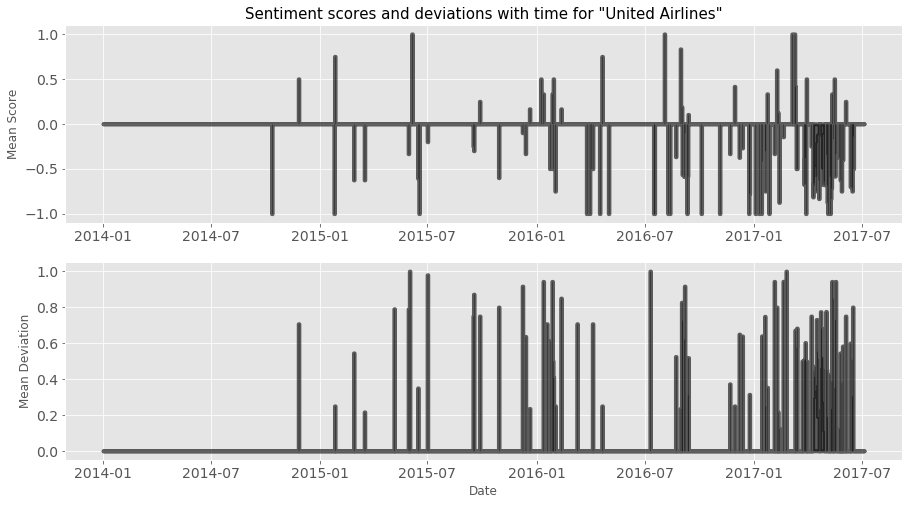

In [38]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))
ax1.fill_between(daily.index, daily['mean_score'], step='mid', color='black', alpha=0.6, linewidth=4);
ax1.set_ylabel('Mean Score');
ax1.set_title('Sentiment scores and deviations with time for "{}"'.format(name), size=15);
ax2.fill_between(daily.index, daily['mean_dev'], step='mid', color='black', alpha=0.6, linewidth=4);
ax2.set_ylabel('Mean Deviation');
ax2.set_xlabel('Date');
# plt.savefig("{}_scores".format('_'.join(name.split()).lower()))

#### Make calendar plot to show periods of activity

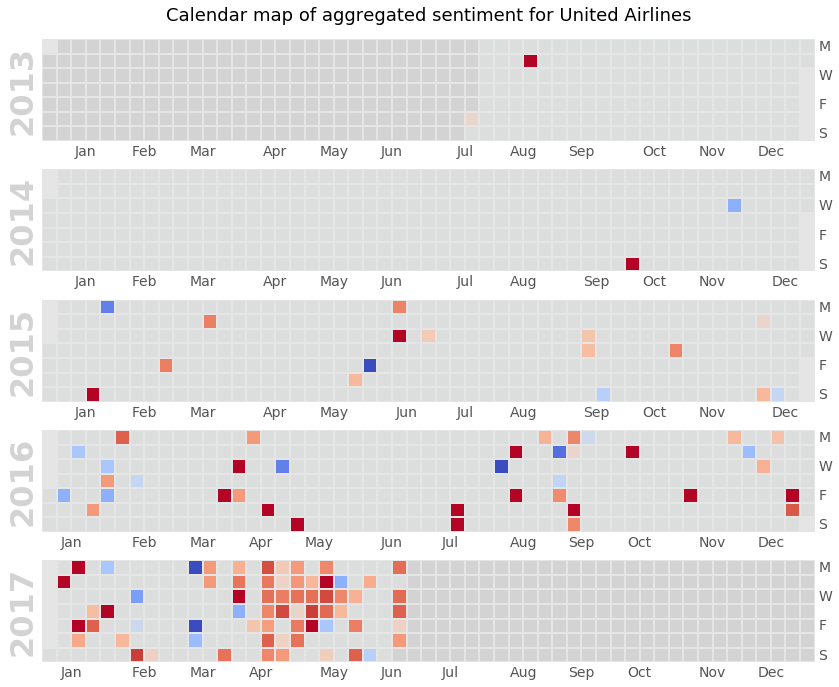

In [45]:
fig, axes = calmap.calendarplot(data['mean_score'],
                    vmin = -1.0,
                    vmax=1.0,
                    daylabels='MTWTFSS',
                    dayticks=[0, 2, 4, 6],
                    fig_kws=dict(figsize=(15, 10)),
                    linewidth=1,
                    fillcolor='lightgrey',
                    cmap='coolwarm_r',
                   );
fig.suptitle("Calendar map of aggregated sentiment for {}".format(name), fontsize=18);
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

if write_:
    out_filename = '_'.join(name.split()).lower()
    plt.savefig('calmap_{}.png'.format(out_filename))

#### Get counts of positive and negative mentions based on Publication

In [41]:
grouped = news_relevant.groupby('publication').apply(lambda x: x['score'] >= 0.0)
grouped = grouped.groupby('publication').value_counts().to_frame()
grouped = grouped.unstack().fillna(0.0)
grouped.columns = ['Negative', 'Positive']
grouped = grouped.sort_values(by='Negative')
grouped

,Negative,Positive
publication,,
Talking Points Memo,0.0,1.0
Fox News,1.0,2.0
National Review,2.0,2.0
Atlantic,3.0,1.0
Buzzfeed News,6.0,2.0
Breitbart,10.0,2.0
Los Angeles Times,13.0,5.0
Guardian,17.0,2.0
New York Times,17.0,7.0


#### Plot article breakdown

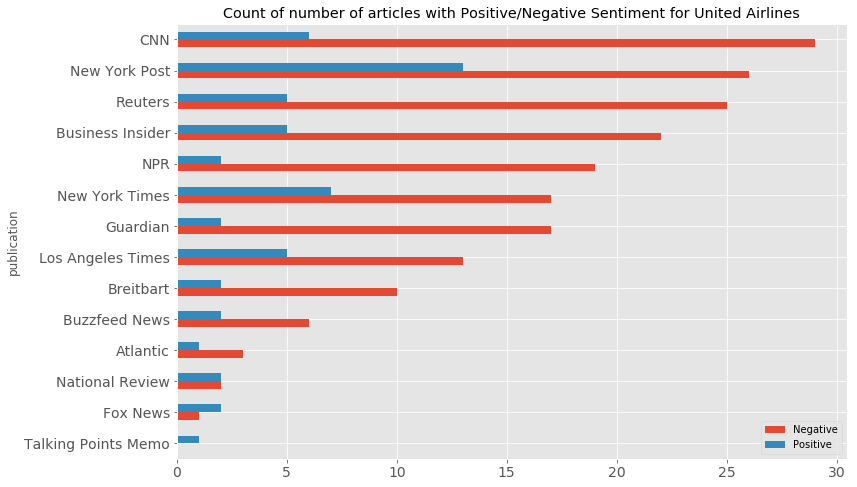

In [42]:
grouped.plot(kind='barh', figsize=(12, 8));
plt.title('Count of number of articles with Positive/Negative Sentiment for {}'.format(name));
# plt.savefig("{}_breakdown".format('_'.join(name.split()).lower()))

#### Output results to CSV

In [43]:
if write_:
    out_filename = '_'.join(name.split()).lower() + '_breakdown.csv'
    out_path = Path('./') / "results/fasttext" / out_filename
    grouped.to_csv(out_path, header=True)

In [44]:
if write_: 
    data_filename = '_'.join(name.split()).lower() + '_data.csv'
    data_path = Path('./') / "results/fasttext" / data_filename
    daily[~daily['relevant'].eq(0)].to_csv(data_path, header=True)